In [20]:
pip install pandas 

Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
df=pd.read_excel("amazon_sales_dataset.xlsx")
df

,Date,Product_ID,Category,Units_Sold,Sales($),Discount(%),Region,Ad_Spend($),Rating
0,2023-04-13,P1160,Clothing,288,36547,15,EU,3677,4.3
1,2023-06-29,P1096,Electronics,226,32471,5,India,3001,3.6
2,2023-04-03,P1180,Electronics,364,18308,30,UK,1487,4.4
3,2023-01-15,P1113,Electronics,370,28532,0,Canada,4788,4.8
4,2023-04-17,P1062,Home,295,35349,0,USA,2861,3.0
...,...,...,...,...,...,...,...,...,...
195,2023-02-20,P1151,Toys,420,36854,30,Canada,1265,3.2
196,2023-06-21,P1194,Beauty,456,47271,10,Canada,475,4.3
197,2023-06-01,P1127,Books,154,9152,25,USA,2133,4.5
198,2023-02-28,P1155,Electronics,210,39518,25,India,245,3.2


In [22]:
df.columns

Index(['Date', 'Product_ID', 'Category', 'Units_Sold', 'Sales($)',
       'Discount(%)', 'Region', 'Ad_Spend($)', 'Rating'],
      dtype='object')

In [23]:
df = df.reset_index(drop=True)

In [24]:
print(df.isnull().sum())  
print(df.shape) 

Date           0
Product_ID     0
Category       0
Units_Sold     0
Sales($)       0
Discount(%)    0
Region         0
Ad_Spend($)    0
Rating         0
dtype: int64
(200, 9)


In [25]:


# Assuming column name is "Sales" (change if different in your file)
df["Sales_Change"] = df["Sales($)"].diff()   # Difference with previous row

# Create a new column to label Up, Down, or No Change
df["Trend"] = df["Sales_Change"].apply(
    lambda x: "Up" if x > 0 else ("Down" if x < 0 else "No Change")
)

# Display result
print(df[["Sales($)", "Sales_Change", "Trend"]].head(10))


   Sales($)  Sales_Change      Trend
0     36547           NaN  No Change
1     32471       -4076.0       Down
2     18308      -14163.0       Down
3     28532       10224.0         Up
4     35349        6817.0         Up
5     46445       11096.0         Up
6      6713      -39732.0       Down
7      5804        -909.0       Down
8     11136        5332.0         Up
9      1009      -10127.0       Down


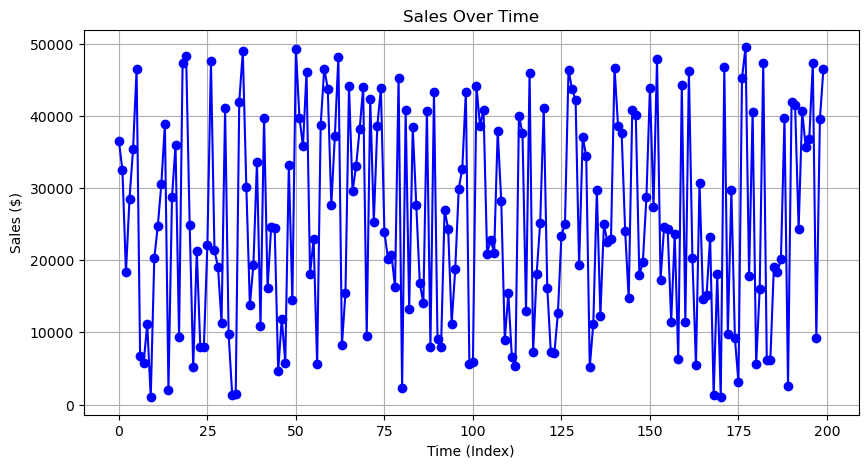

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Assuming your dataframe already has 'Sales($)', 'Sales_Change', and 'Trend'
# If not, add your previous calculation code here

# Line chart for Sales over time
plt.figure(figsize=(10,5))
plt.plot(df.index, df["Sales($)"], marker="o", linestyle="-", color="blue")
plt.title("Sales Over Time")
plt.xlabel("Time (Index)")
plt.ylabel("Sales ($)")
plt.grid(True)
plt.show()

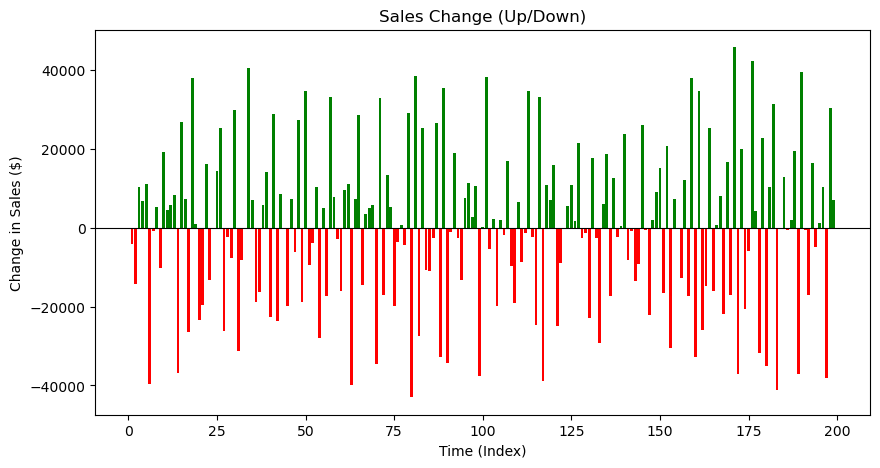

In [27]:
# Bar chart of Sales Change
plt.figure(figsize=(10,5))
plt.bar(df.index, df["Sales_Change"], color=df["Sales_Change"].apply(lambda x: 'green' if x > 0 else 'red'))
plt.title("Sales Change (Up/Down)")
plt.xlabel("Time (Index)")
plt.ylabel("Change in Sales ($)")
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

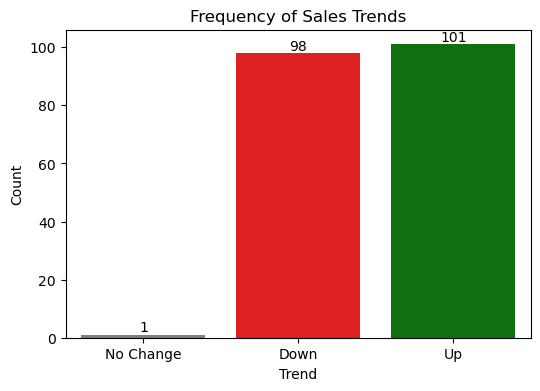

In [28]:
# Count of Trends (Up, Down, No Change)
plt.figure(figsize=(6,4))
ax = sns.countplot(
    x="Trend",
    hue="Trend",   # required for palette mapping
    data=df,
    palette={"Up": "green", "Down": "red", "No Change": "gray"},
    legend=False   # avoid duplicate legend
)

plt.title("Frequency of Sales Trends")
plt.xlabel("Trend")
plt.ylabel("Count")

# Optional: add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.show()


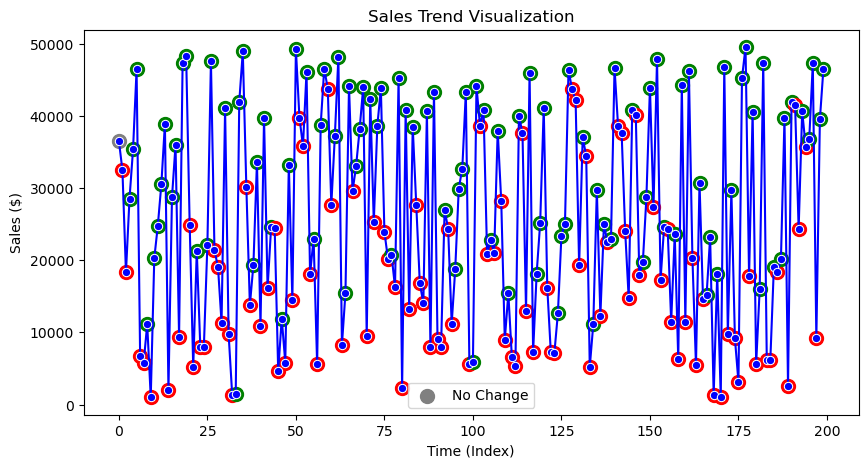

In [29]:
# Line + markers for Up/Down trend visualization
plt.figure(figsize=(10,5))
sns.lineplot(x=df.index, y=df["Sales($)"], marker="o", color="blue")
for i in range(len(df)):
    if df["Trend"].iloc[i] == "Up":
        plt.scatter(df.index[i], df["Sales($)"].iloc[i], color="green", s=100, label="Up" if i == 0 else "")
    elif df["Trend"].iloc[i] == "Down":
        plt.scatter(df.index[i], df["Sales($)"].iloc[i], color="red", s=100, label="Down" if i == 0 else "")
    else:
        plt.scatter(df.index[i], df["Sales($)"].iloc[i], color="gray", s=100, label="No Change" if i == 0 else "")

plt.title("Sales Trend Visualization")
plt.xlabel("Time (Index)")
plt.ylabel("Sales ($)")
plt.legend()
plt.show()




In [30]:
pip install pennylane

Note: you may need to restart the kernel to use updated packages.


In [31]:
# vqc_market_prediction.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [32]:
# -------------------------
# 1. Prepare features/labels
# -------------------------
def prepare_features(df, n_lags=5):
    """
    Build lag features and rolling mean from Sales($).
    df must have 'Sales($)' and 'Trend' (Up/Down/No Change).
    We will drop 'No Change' rows or map them to either class depending on choice.
    """
    df = df.copy()
    # Create lags of Sales and Sales_Change
    for lag in range(1, n_lags + 1):
        df[f"lag_{lag}"] = df["Sales($)"].shift(lag)
    # rolling mean of last n_lags
    df["rolling_mean"] = df["Sales($)"].rolling(window=n_lags).mean()
    # drop NaNs created by shifts/rolling
    df = df.dropna().reset_index(drop=True)
    # Binary label: Up -> 1, Down -> 0. We'll drop "No Change" for clarity.
    df = df[df["Trend"].isin(["Up", "Down"])]
    df["label"] = df["Trend"].map({"Up": 1, "Down": 0})
    feature_cols = [f"lag_{i}" for i in range(1, n_lags + 1)] + ["rolling_mean"]
    X = df[feature_cols].values
    y = df["label"].values.astype(int)
    return X, y, df

In [33]:
# -------------------------
# 2. Preprocess (scale + PCA)
# -------------------------
def preprocess(X, n_qubits=4, test_size=0.2, random_state=42):
    # Standardize
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    # Use PCA to reduce to n_qubits dimensions (quantum encoder size)
    pca = PCA(n_components=n_qubits)
    Xp = pca.fit_transform(Xs)
    # Scale to [-pi/2, pi/2] for angle embedding (not strictly required but helps)
    max_abs = np.abs(Xp).max()
    if max_abs == 0:
        max_abs = 1.0
    Xp = (Xp / max_abs) * (np.pi / 2)
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        Xp, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test, scaler, pca

In [34]:
# -------------------------
# 3. Define VQC with PennyLane
# -------------------------
def create_vqc(n_qubits, n_layers=2):
    dev = qml.device("default.qubit", wires=n_qubits)

    # Angle embedding: encode each feature as rotation around Y
    def embedding(x):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)

    # Variational layer: single-qubit rotations + entangling layer
    def variational_layer(params):
        # params shape: (n_qubits, 3) for RX, RY, RZ
        for i in range(n_qubits):
            qml.RX(params[i, 0], wires=i)
            qml.RY(params[i, 1], wires=i)
            qml.RZ(params[i, 2], wires=i)
        # entangle as a chain
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        # optionally entangle last to first
        qml.CNOT(wires=[n_qubits - 1, 0])

    # The quantum node expects parameters as a flattened vector; we'll reshape inside
    @qml.qnode(dev, interface="autograd")
    def circuit(x, weights):
        # weights shape: (n_layers, n_qubits, 3)
        embedding(x)
        # apply layers
        for l in range(n_layers):
            variational_layer(weights[l])
        # measure expectation of PauliZ on first qubit (binary classification)
        return qml.expval(qml.PauliZ(0))

    # Define a classifier function that maps expectation to [0,1] probability
    def vqc_predict(params, x):
        # params: flattened or shaped accordingly
        exp_val = circuit(x, params)
        # map exp_val in [-1,1] to probability via (1 - exp_val)/2
        prob = (1 - exp_val) / 2
        return prob

    return circuit, vqc_predict


In [35]:
# -------------------------
# 4. Training loop (hybrid)
# -------------------------
def train_vqc(X_train, y_train, X_val, y_val, n_qubits=4, n_layers=2, epochs=50, lr=0.03):
    # Create circuit
    circuit, vqc_predict = create_vqc(n_qubits, n_layers)
    # Initialize weights: shape (n_layers, n_qubits, 3)
    rng = np.random.RandomState(42)
    weights = pnp.array(rng.normal(0, 0.1, size=(n_layers, n_qubits, 3)), requires_grad=True)

    opt = qml.optimize.AdamOptimizer(stepsize=lr)

    train_losses = []
    val_accs = []

    # binary cross-entropy for single sample prediction p (prob) and label y in {0,1}
    def bce_loss(params, x_batch, y_batch):
        losses = []
        for xb, yb in zip(x_batch, y_batch):
            p = vqc_predict(params, xb)
            # numeric stability
            p = pnp.clip(p, 1e-6, 1 - 1e-6)
            loss = - (yb * pnp.log(p) + (1 - yb) * pnp.log(1 - p))
            losses.append(loss)
        return pnp.mean(pnp.stack(losses))

    for ep in range(epochs):
        # mini-batch gradient descent (here full batch for simplicity)
        weights, curr_loss = opt.step_and_cost(lambda w: bce_loss(w, X_train, y_train), weights)
        train_losses.append(float(curr_loss))

        # validation accuracy
        probs_val = np.array([vqc_predict(weights, x) for x in X_val])
        preds_val = (probs_val >= 0.5).astype(int)
        acc = accuracy_score(y_val, preds_val)
        val_accs.append(acc)

        if (ep + 1) % max(1, epochs // 10) == 0:
            print(f"Epoch {ep+1}/{epochs} - Loss: {curr_loss:.4f} - Val Acc: {acc:.4f}")

    return weights, train_losses, val_accs, vqc_predict, circuit

Shapes:  (124, 4) (32, 4) (39, 4)

Classical Logistic Regression Test Accuracy: 0.5897435897435898
              precision    recall  f1-score   support

           0       0.59      0.53      0.56        19
           1       0.59      0.65      0.62        20

    accuracy                           0.59        39
   macro avg       0.59      0.59      0.59        39
weighted avg       0.59      0.59      0.59        39

Epoch 4/40 - Loss: 0.8232 - Val Acc: 0.5000
Epoch 8/40 - Loss: 0.6491 - Val Acc: 0.7188
Epoch 12/40 - Loss: 0.6510 - Val Acc: 0.5938
Epoch 16/40 - Loss: 0.6470 - Val Acc: 0.5938
Epoch 20/40 - Loss: 0.6208 - Val Acc: 0.6562
Epoch 24/40 - Loss: 0.6153 - Val Acc: 0.6875
Epoch 28/40 - Loss: 0.6106 - Val Acc: 0.6875
Epoch 32/40 - Loss: 0.6020 - Val Acc: 0.6562
Epoch 36/40 - Loss: 0.5997 - Val Acc: 0.6562
Epoch 40/40 - Loss: 0.5952 - Val Acc: 0.6562

VQC Test Accuracy: 0.5897435897435898
              precision    recall  f1-score   support

           0       0.64      0.3

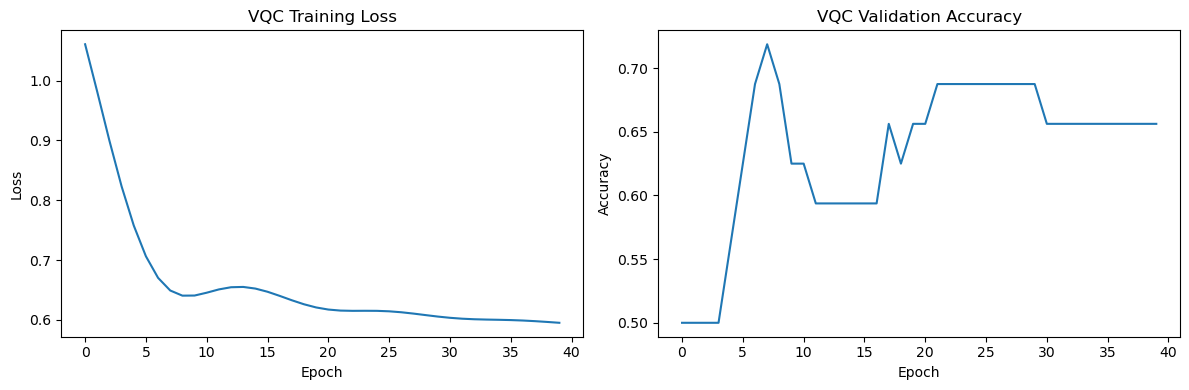


Summary: Logistic Regression acc=0.5897 | VQC acc=0.5897


In [36]:
# -------------------------
# 5. Put it all together
# -------------------------
if __name__ == "__main__":
    # Load your dataframe (change path as needed)
    # df = pd.read_csv("amazon.csv")  # <-- example
    # For this script we assume 'df' is already loaded in the environment and processed earlier.
    # If running standalone, uncomment the above and ensure df has columns: 'Sales($)', 'Sales_Change', 'Trend'
    try:
        df  # check if df exists
    except NameError:
        raise RuntimeError("Dataframe 'df' not found. Load your CSV into df first, and ensure it has 'Sales($)' & 'Trend'.")

    # 1. Prepare features and labels
    X, y, df_clean = prepare_features(df, n_lags=5)

    # 2. Preprocess (scale + PCA -> match qubits)
    n_qubits = 4   # reduce or increase depending on compute budget; keep small for simulators
    X_train_all, X_test, y_train_all, y_test, scaler, pca = preprocess(X, n_qubits=n_qubits)

    # further split train into train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_all, y_train_all, test_size=0.2, random_state=42, stratify=y_train_all
    )

    print("Shapes: ", X_train.shape, X_val.shape, X_test.shape)

    # 3. Train classical baseline
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)
    y_pred_cl = clf.predict(X_test)
    cl_acc = accuracy_score(y_test, y_pred_cl)
    print("\nClassical Logistic Regression Test Accuracy:", cl_acc)
    print(classification_report(y_test, y_pred_cl))

    # 4. Train VQC
    n_layers = 2
    epochs = 40
    lr = 0.05
    weights, train_losses, val_accs, vqc_predict, circuit = train_vqc(
        X_train, y_train, X_val, y_val, n_qubits=n_qubits, n_layers=n_layers, epochs=epochs, lr=lr
    )

    # 5. Evaluate VQC on test set
    probs_test = np.array([vqc_predict(weights, x) for x in X_test])
    preds_test = (probs_test >= 0.5).astype(int)
    vqc_acc = accuracy_score(y_test, preds_test)
    print("\nVQC Test Accuracy:", vqc_acc)
    print(classification_report(y_test, preds_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds_test))

    # 6. Plot training loss and validation accuracy
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(train_losses)
    ax[0].set_title("VQC Training Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")

    ax[1].plot(val_accs)
    ax[1].set_title("VQC Validation Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

    # 7. Quick visualization comparing classical vs quantum
    print(f"\nSummary: Logistic Regression acc={cl_acc:.4f} | VQC acc={vqc_acc:.4f}")


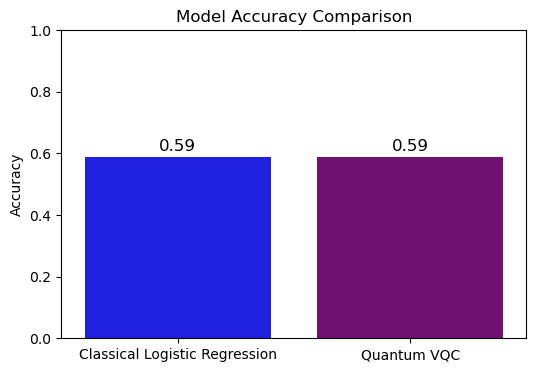

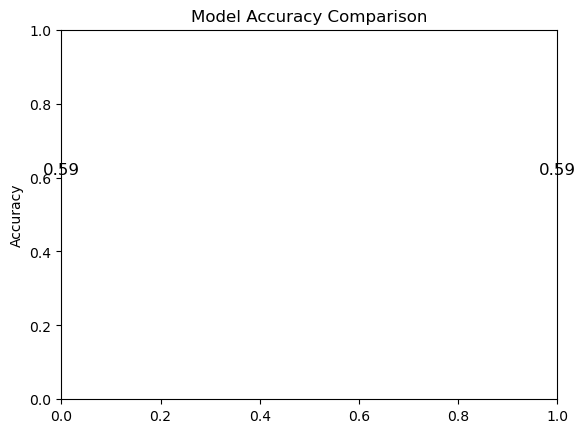

In [44]:

# -----------------------------
# 1. Compare Accuracies
# -----------------------------
plt.figure(figsize=(6, 4))
sns.barplot(
    x=["Classical Logistic Regression", "Quantum VQC"],
    y=[cl_acc, vqc_acc],
    hue=["Classical Logistic Regression", "Quantum VQC"],  # explicitly assign hue
    palette=["blue", "purple"],
    legend=False  # disable extra legend
)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

for i, acc in enumerate([cl_acc, vqc_acc]):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha="center", fontsize=12)

plt.show()
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate([cl_acc, vqc_acc]):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha="center", fontsize=12)
plt.show()


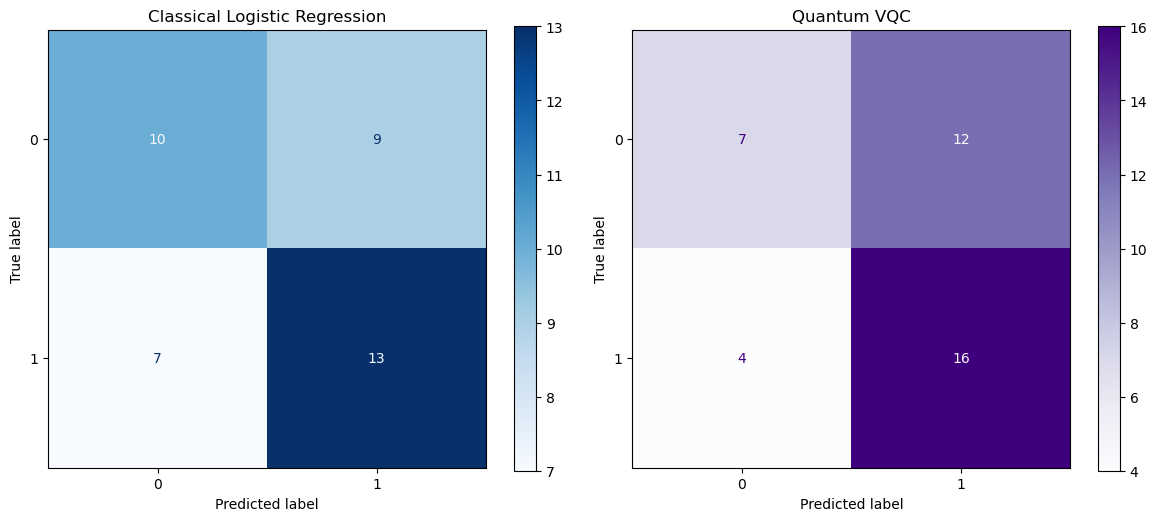

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
# -----------------------------
# 2. Confusion Matrices
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Classical confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_cl, ax=axes[0], cmap="Blues"
)
axes[0].set_title("Classical Logistic Regression")

# Quantum confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, preds_test, ax=axes[1], cmap="Purples"
)
axes[1].set_title("Quantum VQC")

plt.tight_layout()
plt.show()

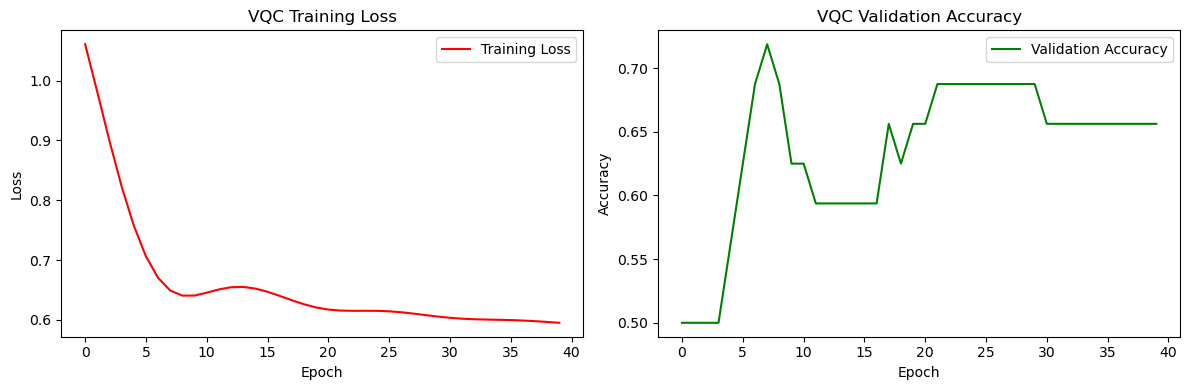

In [46]:
# -----------------------------
# 3. Training Curves (Loss & Accuracy)
# -----------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(train_losses, color="red", label="Training Loss")
ax[0].set_title("VQC Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(val_accs, color="green", label="Validation Accuracy")
ax[1].set_title("VQC Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
pip install --upgrade pip setuptools wheel

21:43:34 - cmdstanpy - INFO - Chain [1] start processing
21:43:38 - cmdstanpy - INFO - Chain [1] done processing


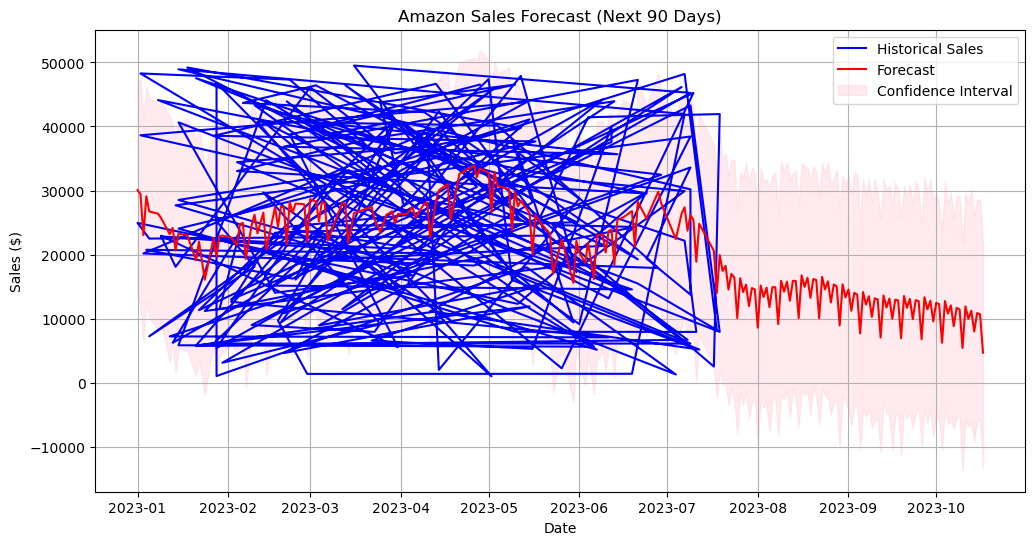

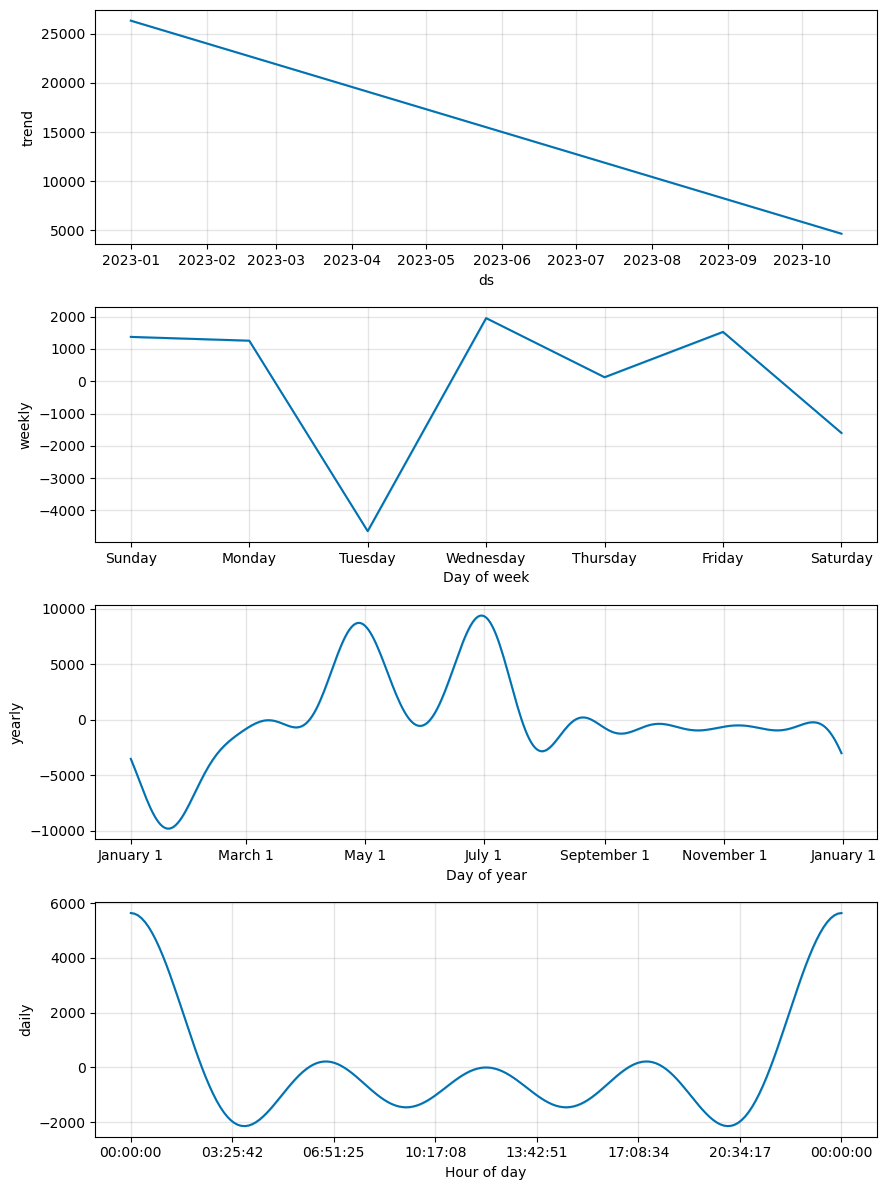

In [54]:
# -----------------------------
# 1. Import Libraries
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# -----------------------------
# 2. Prepare Data
# -----------------------------
# Prophet requires columns: 'ds' (date), 'y' (target)
sales_df = df[["Date", "Sales($)"]].rename(columns={"Date": "ds", "Sales($)": "y"})
sales_df["ds"] = pd.to_datetime(sales_df["ds"])  # ensure datetime format

# -----------------------------
# 3. Train Prophet Model
# -----------------------------
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True  # added for completeness
)
model.fit(sales_df)

# -----------------------------
# 4. Forecast Future Sales
# -----------------------------
future = model.make_future_dataframe(periods=90)  # forecast 90 days ahead
forecast = model.predict(future)

# -----------------------------
# 5. Plot Forecast
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(sales_df["ds"], sales_df["y"], label="Historical Sales", color="blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="red")
plt.fill_between(
    forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"],
    color="pink", alpha=0.3, label="Confidence Interval"
)
plt.title("Amazon Sales Forecast (Next 90 Days)")
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 6. Prophet Components (Trend & Seasonality)
# -----------------------------
fig = model.plot_components(forecast)
plt.show()
